# Variational Quantum Time Evolution
This notebook demonstrates how to use the Variational Quantum Time Evolution (VarQTE) algorithm for computing the time evolving state under a given Hamiltonian. Specifically, it introduces variational quantum imaginary and real time evolution based on McLachlan's variational principle, and shows how this can be leveraged using the `time_evolvers.variational` sub-module.

## Introduction
The time evolution of a quantum state $|\Psi\rangle$ is governed by the Schrödinger equation (here with $\hbar \equiv 1$)

$$
    \frac{d}{dt} |\Psi(t)\rangle = -i H |\Psi(t)\rangle,
$$


or without the factor $i$ for imaginary time dynamics.

In VarQTE, the time evolution of the _state_ $|\Psi(t)\rangle$ is replaced by the evolution of _parameters_ $\theta(t)$ in a variational ansatz $|\psi[\theta(t)]$ ([Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)). Using the McLachlan variational principle, the algorithm updates the parameters by minimizing the distance between the right-hand side and left-hand side of the equation above, that is

$$
\dot\theta(t) = \mathrm{argmin} \Bigg\| \left(\frac{d}{dt} + i H\right)|\psi[\theta(t)]\rangle \Bigg\|,
$$

with the norm $\| |\psi\rangle \| = \sqrt{\langle\psi | \psi\rangle}$. This is equivalent to solving the following linear system of equations

$$
\sum_{ij}F_{ij}\dot{\theta}_{i}=V_{j}
$$

where

$$F_{ij}=\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}+\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\left|\psi\left[\theta\right]\right\rangle \left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}\right]$$,

and

$$V_{i}=\begin{cases}
\text{Im}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle +\left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{i}}\left\langle H\right\rangle _{\theta}\right] & \text{Real time}\\
-\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle \right] & \text{Imaginary time}
\end{cases}$$.


## Running VarQTE

In this tutorial, we will use two classes that extend `VarQTE`, `VarQITE` ([Variational Quantum Imaginary Time Evolution](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VarQITE.html#qiskit_algorithms.VarQITE)) and `VarQRTE` ([Variational Quantum Real Time Evolution](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VarQRTE.html)) for time evolution.
We can use a simple Ising model on a spin chain to illustrate this. Let us consider the following Hamiltonian:

$$H = -J\sum_{i=0}^{L-2}Z_{i}Z_{i+1} - h\sum_{i=0}^{L-1}X_i$$

where $J$ stands for the interaction energy, and
$h$ represents an external field which is orthogonal to the transverse direction. $Z_i$ and $X_i$ are the Pauli operators on the spins. Taking $L=2$, $J=0.2$,  and $h =1$, the Hamiltonian and the magnetization $\sum_i Z_i$ can be constructed using `SparsePauliOp` as follows:

In [1]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp(["ZZ", "IX", "XI"], coeffs=[-0.2, -1, -1])

magnetization = SparsePauliOp(["IZ", "ZI"], coeffs=[1, 1])

## Imaginary Time Evolution

Imaginary time evolution can be used, for example, to find the ground state or calculate the finite temperature expectation value of the system. Here, we will use the `VarQITE` class from `time_evolvers.variational` to compute a ground state energy. Firstly, we need to choose an ansatz. We can use `EfficientSU2` to easily construct an ansatz, setting the number of repetitions using `reps`.

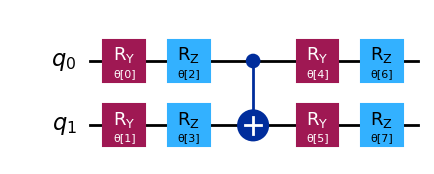

In [2]:
from qiskit.circuit.library import efficient_su2

ansatz = efficient_su2(hamiltonian.num_qubits, reps=1)
ansatz.draw("mpl")

Here, we prepare a dictionary to store the initial parameters we set up, which determine the initial state.

In [3]:
import numpy as np

init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.pi / 2

Note that the initial state should be in overlap with the ground state.

Next, we choose `ImaginaryMcLachlanPrinciple` as the variational principle we'll use later.

In [4]:
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple

var_principle = ImaginaryMcLachlanPrinciple()

We set a target imaginary time $t=5$, and set the Hamiltonian as an auxiliary operator. We create  a `TimeEvolutionProblem` instance with `hamiltonian`, `time`, and `aux_operators` as arguments.

In [5]:
from qiskit_algorithms import TimeEvolutionProblem

time = 5.0
aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)

We now use the `VarQITE` class to calculate the imaginary time evolving state. We can use `VarQITE.evolve` to get the results. Note this cell may take around  $1.5$  minutes to finish.

In [6]:
from qiskit_algorithms import VarQITE
from qiskit.primitives import StatevectorEstimator

var_qite = VarQITE(ansatz, init_param_values, var_principle, StatevectorEstimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)

### Exact Classical Solution
In order to check whether our calculation using `VarQITE` is correct or not, we also call `SciPyImaginaryEvolver` to help us calculate the exact solution.

Firstly, we can use `qiskit.quantum_info.Statevector` to help us get the statevector from the quantum circuit.

In [7]:
from qiskit.quantum_info import Statevector

init_state = Statevector(ansatz.assign_parameters(init_param_values))

Then we can set up the evolving problem using `SciPyImaginaryEvolver`. Here we set number of time steps as $501$.

In [8]:
from qiskit_algorithms import SciPyImaginaryEvolver

evolution_problem = TimeEvolutionProblem(
    hamiltonian, time, initial_state=init_state, aux_operators=aux_ops
)
exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
sol = exact_evol.evolve(evolution_problem)

### Results and Comparison

We use `evolution_result.observables` to get the variation over time of the expectation values of the Hamiltonian.

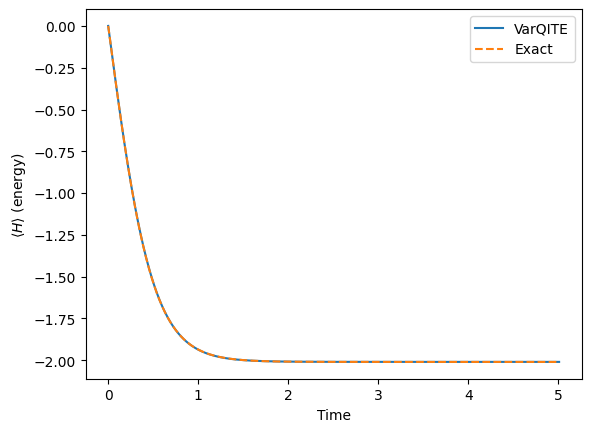

In [9]:
import pylab

h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

exact_h_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, h_exp_val, label="VarQITE")
pylab.plot(times, exact_h_exp_val, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [10]:
print("Ground state energy", h_exp_val[-1])

Ground state energy -2.009747907952119


As the above figure indicates, we have obtained the converged ground state energy.

### Efficient classical calculation of gradients with VarQITE

You can use classically efficient gradient calculations to speed up the time evolution simulation by setting `qgt` to `ReverseQGT()` and `gradient` to `ReverseEstimatorGradient()`.

In [11]:
from qiskit_algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

var_principle = ImaginaryMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, StatevectorEstimator())
evolution_result_eff = var_qite.evolve(evolution_problem)

In this example, it takes only $1$ minute to calculate imaginary time evolution. The execution time is reduced by about 33% (this may vary for each execution, but generally results in a speedup).

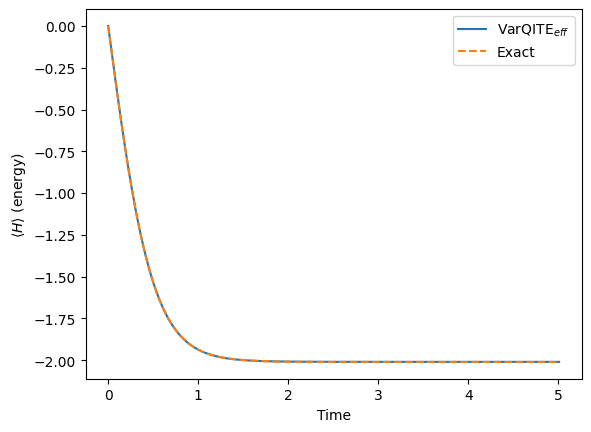

In [12]:
h_exp_val_eff = np.array([ele[0][0] for ele in evolution_result_eff.observables])

exact_h_exp_val_eff = sol.observables[0][0].real

times = evolution_result_eff.times
pylab.plot(times, h_exp_val_eff, label=r"VarQITE$_{eff}$")
pylab.plot(times, exact_h_exp_val_eff, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

We can also get a converged result, which is consistent with the previous one.

In [13]:
print("Ground state energy", h_exp_val_eff[-1])

Ground state energy -2.0097479079521183




Let us compare the performance of different methods. The error is defined as the difference between the results and exact solution for each method.

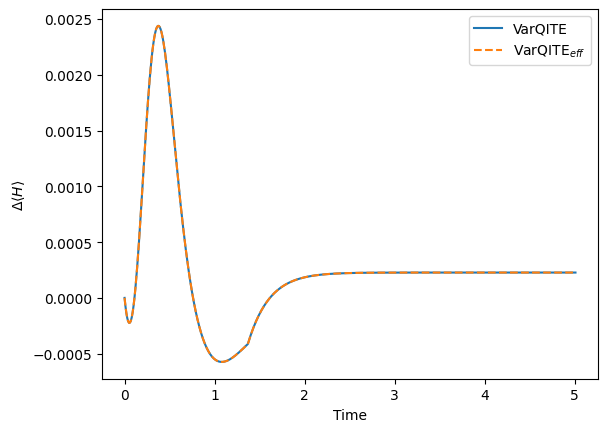

In [14]:
pylab.plot(times, (h_exp_val - exact_h_exp_val), label="VarQITE")
pylab.plot(times, (h_exp_val_eff - exact_h_exp_val_eff), label=r"VarQITE$_{eff}$", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\Delta \langle H \rangle$")
pylab.legend(loc="upper right");

In this task, the accuracies of `VarQITE` with both gradient methods are very close, but `ReverseEstimatorGradient()` takes a considerably shorter time to run.

We can do the same comparison for `VarQRTE` for simulating the magnetization of the Ising model.

## Real Time Evolution
Real time evolution is more suitable for tasks such as simulating quantum dynamics. For example, one can use `VarQRTE` to get time evolving expectation values of the magnetization.


### VarQRTE
Again, the first step is to select an ansatz.

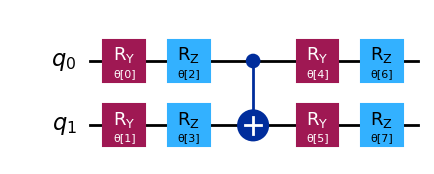

In [15]:
ansatz = efficient_su2(hamiltonian.num_qubits, reps=1)
ansatz.draw("mpl")

We set all initial parameters as $\frac{\pi}{2}$.

In [16]:
init_param_values = {}

for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = (
        np.pi / 2
    )  # initialize the parameters which also decide the initial state

We also define an initial state:

In [17]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))
print(init_state)

Statevector([-5.00000000e-01+0.00000000e+00j,
             -5.00000000e-01-5.55111512e-17j,
              0.00000000e+00-5.00000000e-01j,
              1.66533454e-16+5.00000000e-01j],
            dims=(2, 2))


In order to use the real time McLachlan principle, we instantiate the `RealMcLachlanPrinciple` class.

In [18]:
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple

var_principle = RealMcLachlanPrinciple()

We also set the target time as $t=10$, and set the auxiliary operator to be the magnetization operator. The following steps are similar to `VarQITE`.


In [19]:
aux_ops = [magnetization]

In [20]:
from qiskit_algorithms import VarQRTE

time = 10.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qrte = VarQRTE(ansatz, init_param_values, var_principle, StatevectorEstimator())
evolution_result_re = var_qrte.evolve(evolution_problem)

We can also obtain the exact solution with `SciPyRealEvolver`. We first create the corresponding initial state for the exact classical method.

In [21]:
init_circ = ansatz.assign_parameters(init_param_values)

`SciPyRealEvolver` can help us get the classical exact result.

In [22]:
from qiskit_algorithms import SciPyRealEvolver

evolution_problem = TimeEvolutionProblem(
    hamiltonian, time, initial_state=init_circ, aux_operators=aux_ops
)
rtev = SciPyRealEvolver(1001)
sol = rtev.evolve(evolution_problem)

We can compare the results, where $m_z$ represents the magnetization.

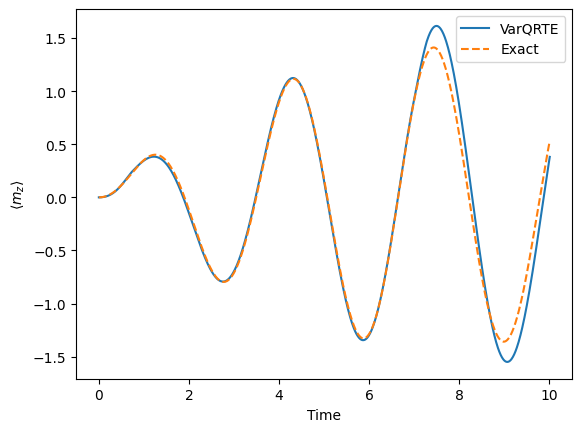

In [23]:
mz_exp_val_re = np.array([ele[0][0] for ele in evolution_result_re.observables])
exact_mz_exp_val_re = sol.observables[0][0].real
times = evolution_result_re.times
pylab.plot(times, mz_exp_val_re, label="VarQRTE")
pylab.plot(times, exact_mz_exp_val_re, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle m_z \rangle$")
pylab.legend(loc="upper right");

### Efficient Way to run VarQRTE

Similarly, we can set `qpt` as `ReverseQGT()` and `gradient` as `ReverseEstimatorGradient()` to speed up the calculation.

In [24]:
from qiskit_algorithms.gradients import DerivativeType

var_principle = RealMcLachlanPrinciple(
    qgt=ReverseQGT(), gradient=ReverseEstimatorGradient(derivative_type=DerivativeType.IMAG)
)
time = 10.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qrte = VarQRTE(ansatz, init_param_values, var_principle, StatevectorEstimator())
evolution_result_re_eff = var_qrte.evolve(evolution_problem)

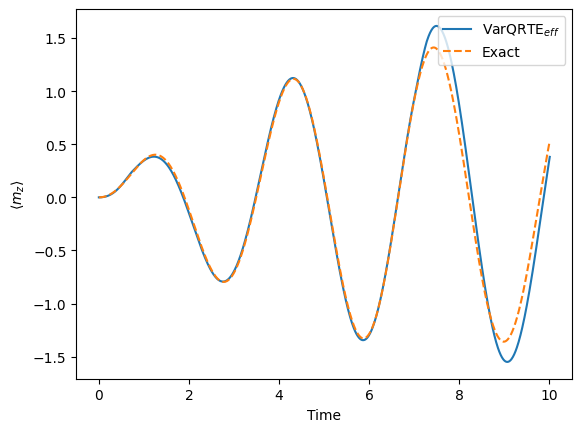

In [25]:
mz_exp_val_re_eff = np.array([ele[0][0] for ele in evolution_result_re_eff.observables])
pylab.plot(times, mz_exp_val_re_eff, label=r"VarQRTE$_{eff}$")
pylab.plot(times, exact_mz_exp_val_re, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle m_z \rangle$")
pylab.legend(loc="upper right");

Again, the accuracies of `VarQRTE` with both gradient methods are very similar, while the `ReverseEstimatorGradient()` shows a speedup of about $21\%$ in this execution.

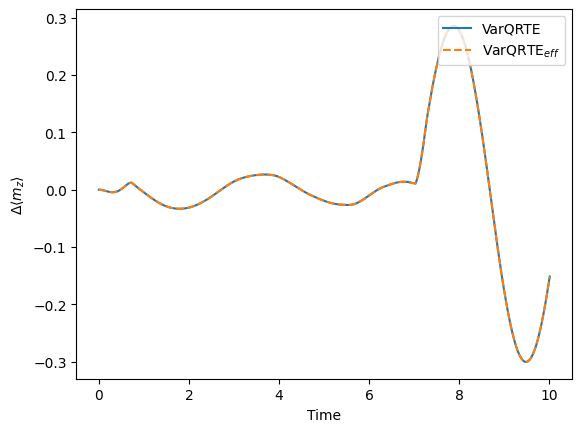

In [26]:
pylab.plot(times, (mz_exp_val_re - exact_mz_exp_val_re), label="VarQRTE")
pylab.plot(
    times, (mz_exp_val_re_eff - exact_mz_exp_val_re), label=r"VarQRTE$_{eff}$", linestyle="--"
)
pylab.xlabel("Time")
pylab.ylabel(r"$\Delta \langle m_z \rangle$")
pylab.legend(loc="upper right");

In [27]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright